#Henry Echt

#Data Mining and Machine Learning Final
#Predicting UFC Winners

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# url = 'https://drive.google.com/file/d/1yTlLZAlQWe3BHWp2knHr4AsOPNK1yczs/view?usp=sharing'
df = pd.read_csv('/content/data.csv')

###Read data into dataframe

In [ ]:
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


###Examine First 5 rows of the dataframe

In [ ]:
df[['B_age', 'R_age']].fillna(df[['B_age', 'R_age']].mean(), inplace=True)

# Remove columns with more than 20% missing values
threshold = 20  # Percent
high_missing_cols = df.columns[df.isnull().mean() > (threshold / 100)]
for col in high_missing_cols:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Impute missing values for columns with 5% to 20% missing values
moderate_missing_cols = df.columns[(df.isnull().mean() > 0.05) & (df.isnull().mean() <= 0.20)]
for col in moderate_missing_cols:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)


<ipython-input-3-d118359f751b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['B_age', 'R_age']].fillna(df[['B_age', 'R_age']].mean(), inplace=True)


###For columns that have more than 20% of their values as na, fill with the median of all values in the column
###For columns that have in between 5% to 20% of their values as na, fill with the median of all values in the column

In [ ]:
# Convert percentage strings to floats
df.replace({'%': ''}, regex=True, inplace=True)  # Remove percentage signs
percent_cols = [col for col in df.columns if 'pct' in col]  # Columns containing percentages
df[percent_cols] = df[percent_cols].apply(pd.to_numeric, errors='coerce') / 100  # Convert to float and scale

###Change all values that are a percent in each column(that contains percentages) into floats

In [ ]:
df = pd.get_dummies(df, columns=['weight_class', 'R_Stance', 'B_Stance'], drop_first=True)

###Encode weight class, r_stance, and b_stance

In [ ]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Check conversions
df[percent_cols].head(), df['date'].head()

# Calculate the absolute difference in total number of fights
df['experience_diff'] = abs(df['R_total_rounds_fought'] - df['B_total_rounds_fought'])

# Calculate the absolute physical advantage (Height and Reach)
df['height_diff'] = abs(df['R_Height_cms'] - df['B_Height_cms'])
df['reach_diff'] = abs(df['R_Reach_cms'] - df['B_Reach_cms'])

# Calculate the absolute age difference
df['age_diff'] = abs(df['R_age'] - df['B_age'])




#For expierence difference, height difference, reach difference, and age difference.

## if number is positive - advantage to red corner
## if number is negative - Advantage to Blue Corner

In [ ]:
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,...,R_Stance_Southpaw,R_Stance_Switch,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,experience_diff,height_diff,reach_diff,age_diff
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.000000,0.0,0.004200,...,False,False,True,False,False,False,3,5.08,7.62,4.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.500000,0.0,0.006600,...,False,False,True,False,False,False,13,5.08,5.08,4.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.015625,0.0,0.004500,...,True,False,True,False,False,False,13,0.00,0.00,4.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.015625,0.0,0.004500,...,False,True,False,False,True,False,0,7.62,5.08,3.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.125000,0.0,0.005356,...,False,False,True,False,False,False,19,12.70,10.16,14.0


###Examine the first 5 values of the newley wrangled dataframe

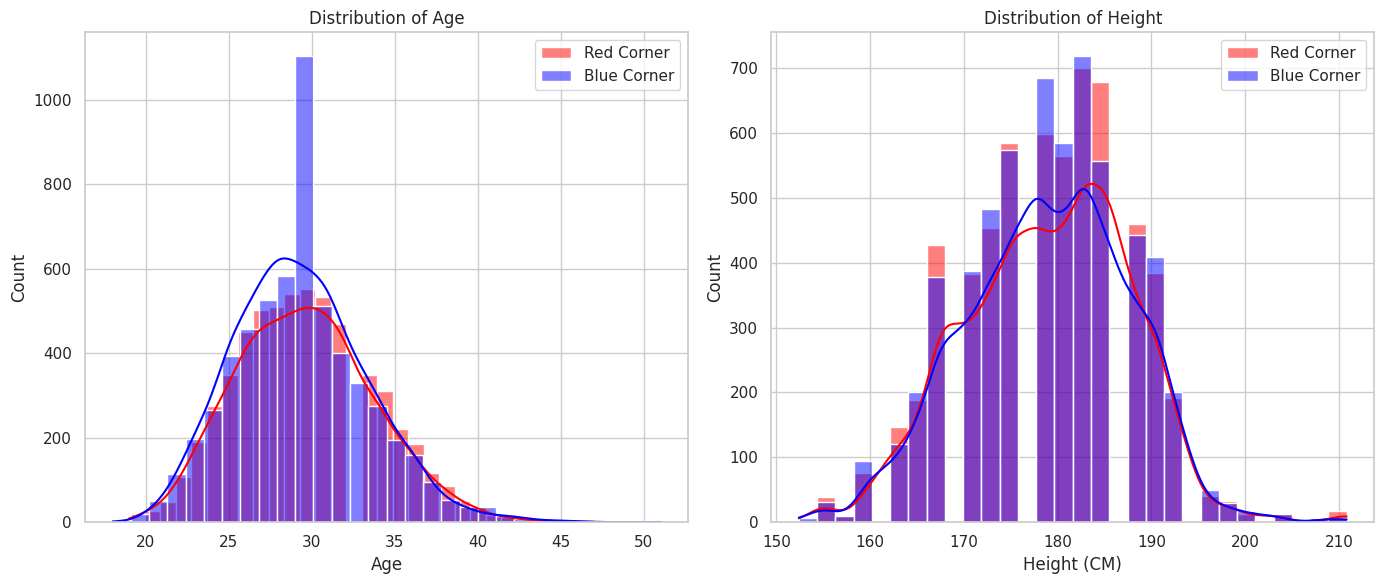

In [ ]:
sns.set(style="whitegrid")

# Distribution of Age
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='R_age', bins=30, color='red', kde=True, label='Red Corner')
sns.histplot(data=df, x='B_age', bins=30, color='blue', kde=True, label='Blue Corner')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.legend()

# Distribution of Height
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='R_Height_cms', bins=30, color='red', kde=True, label='Red Corner')
sns.histplot(data=df, x='B_Height_cms', bins=30, color='blue', kde=True, label='Blue Corner')
plt.title('Distribution of Height')
plt.xlabel('Height (CM)')
plt.legend()

plt.tight_layout()
plt.show()

###Plot a count and age for both red and blue corners at each age. At each age, the count is how many fights the blues and reds corners have had (at that given age).
###Do the same for height.

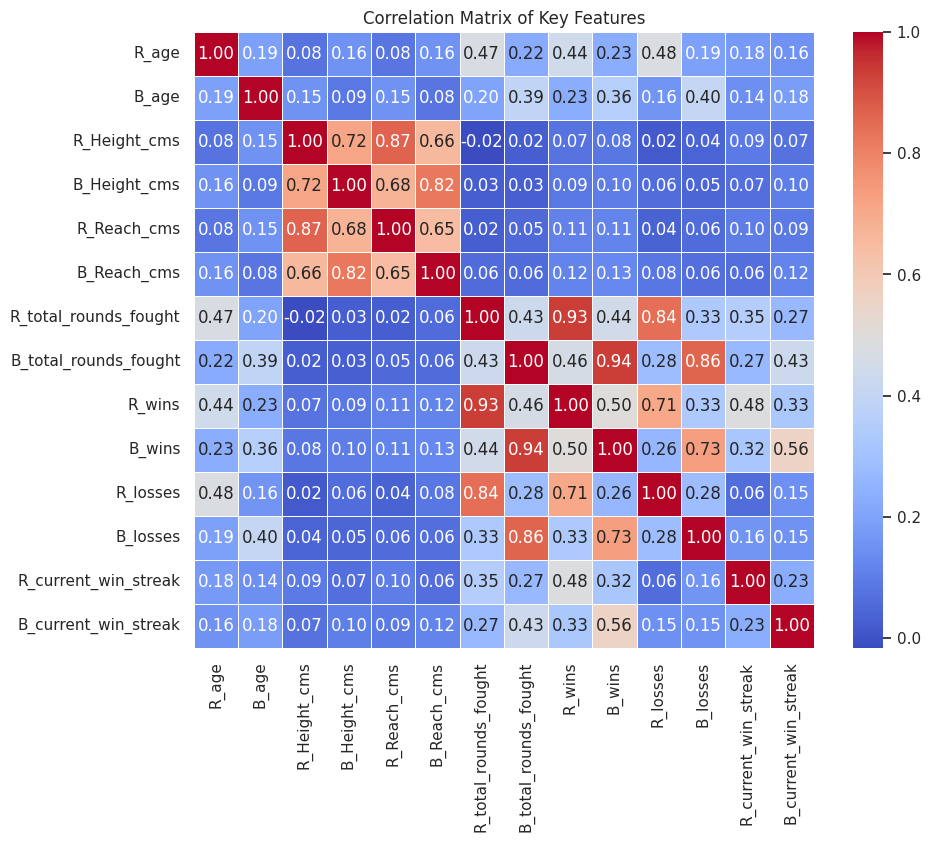

In [ ]:
# Correlation matrix focusing on some key features related to fight outcome
key_features = ['R_age', 'B_age', 'R_Height_cms', 'B_Height_cms', 'R_Reach_cms', 'B_Reach_cms',
                'R_total_rounds_fought', 'B_total_rounds_fought', 'R_wins', 'B_wins',
                'R_losses', 'B_losses', 'R_current_win_streak', 'B_current_win_streak']
correlation_matrix = df[key_features].corr()

# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features')
plt.show()

# Create a new feature for fight outcome as a numeric variable (1 if Red wins, 0 if Blue wins)
df['winner_is_red'] = (df['Winner'] == 'Red').astype(int)

# Average win streaks by winner
avg_win_streak_by_winner = df.groupby('Winner')[['R_current_win_streak', 'B_current_win_streak']].mean()

# Total rounds fought in database
df['Total_Rounds_Fought'] = df['R_total_rounds_fought'] + df['B_total_rounds_fought']



###Make a correlation matrix (shows how variables relate to each other). Helps identify feature importance and shows which values are important to a fighter winning a certain match (closer to 1, more important it is).
###Make a variable that holds the average win streak per winner.
###Create a new column that holds "total rounds fought", this holds the total rounds fought as a sum from the blue and red corner.

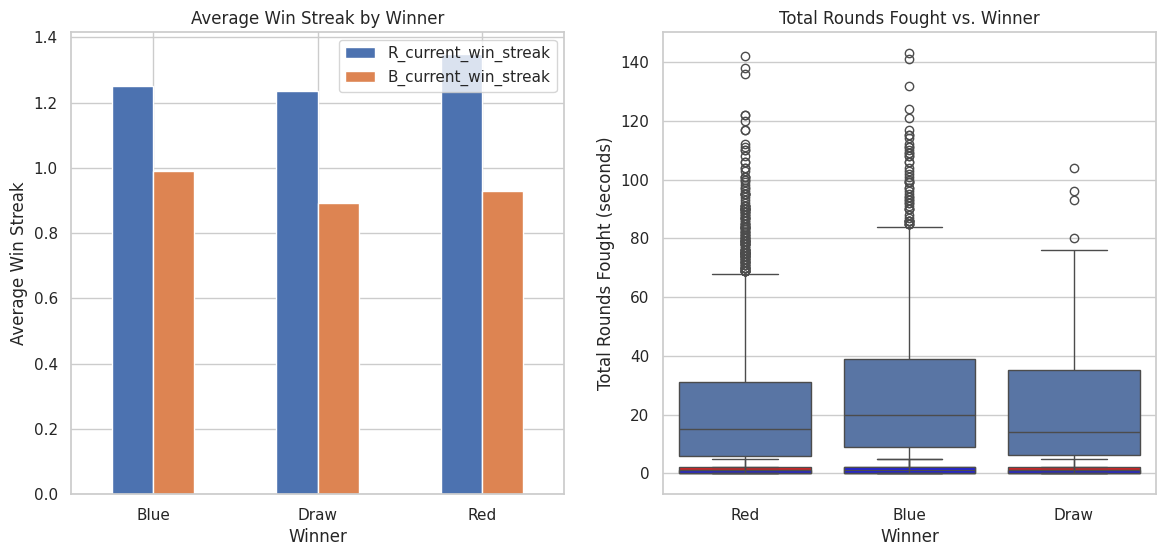

<Figure size 640x480 with 0 Axes>

In [ ]:
# Box plot of win streaks vs winner
plt.figure(figsize=(14, 6))

# Bar chart of average win streaks
plt.subplot(1, 2, 1)
avg_win_streak_by_winner.plot(kind='bar', ax=plt.gca())
plt.title('Average Win Streak by Winner')
plt.ylabel('Average Win Streak')
plt.xlabel('Winner')
plt.xticks(rotation=0)

# Box plot of Red and Blue corner win streaks for winners
plt.subplot(1, 2, 2)
sns.boxplot(x='Winner', y='R_current_win_streak', data=df, color='red', showfliers=False)
sns.boxplot(x='Winner', y='B_current_win_streak', data=df, color='blue', showfliers=False, ax=plt.gca())
plt.title('Distribution of Win Streaks by Winner')
plt.ylabel('Win Streak')
plt.xlabel('Winner')

# Now plot using this new column
sns.boxplot(x='Winner', y='Total_Rounds_Fought', data=df)
plt.title('Total Rounds Fought vs. Winner')
plt.xlabel('Winner')
plt.ylabel('Total Rounds Fought (seconds)')
plt.show()
plt.tight_layout()
plt.show()

###Plot average win streak by winner as grouped bar chart. This shows the average win streak of the fighters during a win or draw per corner.

###Plot total rounds fought vs. Winner as a boxplot. If a fighter from the Red corner wins, this shows that they probrably have fought somwhere from 8-35 rounds. Same goes with blue but different values, along with a draw.

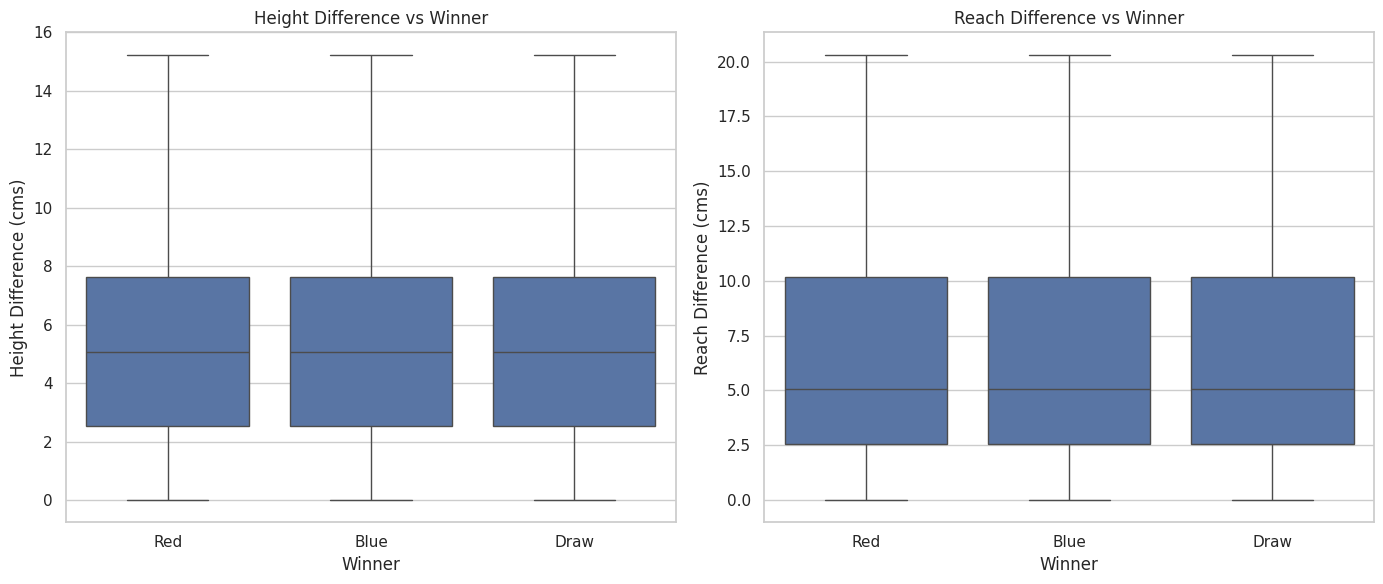

In [ ]:
# Plotting the effect of height and reach differences
plt.figure(figsize=(14, 6))

# Height Difference vs. Winner
plt.subplot(1, 2, 1)
sns.boxplot(x='Winner', y='height_diff', data=df, showfliers=False)
plt.title('Height Difference vs Winner')
plt.xlabel('Winner')
plt.ylabel('Height Difference (cms)')

# Reach Difference vs. Winner
plt.subplot(1, 2, 2)
sns.boxplot(x='Winner', y='reach_diff', data=df, showfliers=False)
plt.title('Reach Difference vs Winner')
plt.xlabel('Winner')
plt.ylabel('Reach Difference (cms)')

plt.tight_layout()
plt.show()

###BoxPlot height difference vs. Winner. This shows that the average height different between fighters after they win is betwwen 2.5 and 7.75 cms.

###BoxPlot Reach difference vs. Winner. This shows that the average reach different between fighters after they win is betwwen 2.5 and 10 cms.

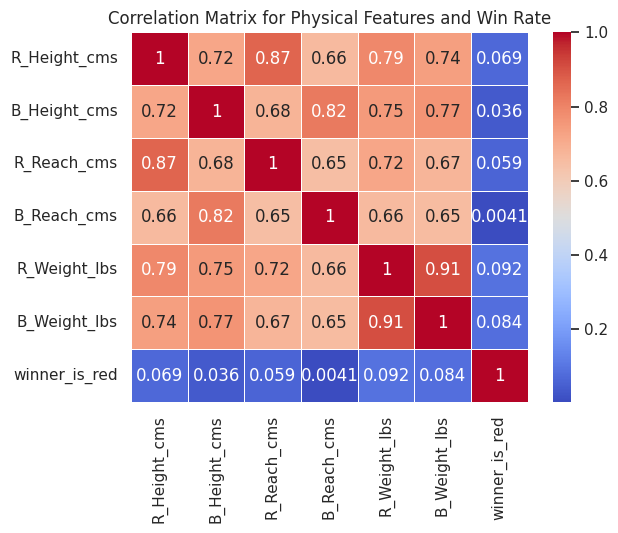

In [ ]:
correlation_matrix = df[['R_Height_cms', 'B_Height_cms','R_Reach_cms', 'B_Reach_cms', 'R_Weight_lbs', 'B_Weight_lbs','winner_is_red']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for Physical Features and Win Rate')
plt.show()

###The heatmap visually represents the correlation between physical attributes of fighters (such as height, reach, and weight) and their win rate, with values ranging from -1 to 1. It offers insights into whether certain physical characteristics tend to correlate with a higher likelihood of winning a match.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Columns: 168 entries, R_fighter to Total_Rounds_Fought
dtypes: bool(22), datetime64[ns](1), float64(109), int64(31), object(5)
memory usage: 6.8+ MB


In [ ]:
num_imputer = SimpleImputer(strategy='mean')
df[['B_avg_KD', 'R_Reach_cms', 'B_age', 'R_age']] = num_imputer.fit_transform(df[['B_avg_KD', 'R_Reach_cms', 'B_age', 'R_age']])

#cat_imputer = SimpleImputer(strategy='most_frequent')


###Use a simple imputer to traverse through df[['B_avg_KD', 'R_Reach_cms', 'B_age', 'R_age']] and fill in all Na values with the mean in that column.


In [ ]:
df_dummies = pd.get_dummies(df, columns=['R_Stance_Orthodox',	'R_Stance_Sideways',	'R_Stance_Southpaw',	'R_Stance_Switch',
                                         'B_Stance_Orthodox',	'B_Stance_Sideways',	'B_Stance_Southpaw',	'B_Stance_Switch',], drop_first=True)



###Create a new dataframe that one hot encodes a bunch of columns. this dataframe will be used to make our training / testing data later on.

In [ ]:
df_dummies.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,...,winner_is_red,Total_Rounds_Fought,R_Stance_Orthodox_True,R_Stance_Sideways_True,R_Stance_Southpaw_True,R_Stance_Switch_True,B_Stance_Orthodox_True,B_Stance_Sideways_True,B_Stance_Southpaw_True,B_Stance_Switch_True
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.000000,0.0,0.004200,...,1,5,True,False,False,False,True,False,False,False
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.500000,0.0,0.006600,...,1,21,True,False,False,False,True,False,False,False
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.015625,0.0,0.004500,...,1,13,False,False,True,False,True,False,False,False
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.015625,0.0,0.004500,...,0,0,False,False,False,True,False,False,True,False
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.125000,0.0,0.005356,...,0,41,True,False,False,False,True,False,False,False


###One Hot encode 'R_Stance_Orthodox',	'R_Stance_Sideways',	'R_Stance_Southpaw',	'R_Stance_Switch', 'B_Stance_Orthodox',	'B_Stance_Sideways',	'B_Stance_Southpaw',	'B_Stance_Switch'


In [ ]:
X = df_dummies[['height_diff', 'reach_diff', 'R_Stance_Orthodox_True', 'R_Stance_Southpaw_True', 'B_Stance_Orthodox_True', 'B_Stance_Southpaw_True']]
y = df_dummies['winner_is_red']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer object with a strategy to fill missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Create a logistic regression model with a pipeline
model = make_pipeline(imputer, LogisticRegression())

# Fit the model
model.fit(X_train, y_train)

# Predictions and Report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       401
           1       0.67      1.00      0.80       802

    accuracy                           0.67      1203
   macro avg       0.33      0.50      0.40      1203
weighted avg       0.44      0.67      0.53      1203



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

###Make our testing data and training data through df_dummies.
###impute X_train by mean
###Make and fit the model(Logistic Regression)
###Print out and analyze classification report.

In [ ]:
# Create the XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

# Fit and evaluate the model using cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5)
print(f"CV Scores: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean():.2f}")

CV Scores: [0.65918537 0.65586035 0.6530782  0.66056572 0.65723794]
Average CV Score: 0.66


###Make a XGBClassifier and cross valid curve 5 folds, also find the average and print each score per cv value.

In [ ]:
# Define the GBM model
gbm_model = make_pipeline(imputer, GradientBoostingClassifier(n_estimators=250, learning_rate=0.00001, max_depth=8, random_state=42))

# Train the model
gbm_model.fit(X_train, y_train)

# Evaluate the model
gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)
print("Gradient Boosting Model Classification Report:")
print(classification_report(y_test, gbm_predictions))




Gradient Boosting Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       401
           1       0.67      1.00      0.80       802

    accuracy                           0.67      1203
   macro avg       0.33      0.50      0.40      1203
weighted avg       0.44      0.67      0.53      1203



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

###Make and Fit a XGB model and print / analyze classification report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['R_Height_cms', 'B_Height_cms', 'R_Reach_cms', 'B_Reach_cms', 'R_Weight_lbs', 'B_Weight_lbs']],
    df['winner_is_red'],
    test_size=0.2,
    random_state=42
)

imputer = SimpleImputer(strategy='mean')

model = make_pipeline(imputer, RandomForestClassifier(n_estimators=200, random_state=42))

model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.43      0.32      0.37       401
           1       0.70      0.79      0.74       802

    accuracy                           0.63      1203
   macro avg       0.57      0.56      0.56      1203
weighted avg       0.61      0.63      0.62      1203

Accuracy: 0.6334164588528678


###Make new testing and training data
###Make and fit a Random forest model with n_estimators=200 and random_state = 42
###Print and analyze classification report

In [ ]:
model = RandomForestClassifier(random_state=42)

pipeline = make_pipeline(SimpleImputer(strategy='mean'), model)

k = 5

cv_scores = cross_val_score(pipeline, X, y, cv=k)

print(f"CV Scores for {k} folds:", cv_scores)
print(f"Average CV Score:", cv_scores.mean())


CV Scores for 5 folds: [0.61679135 0.63757273 0.64642263 0.65224626 0.63311148]
Average CV Score: 0.6372288911664266


###Make a RandomForestClassifier and cross valid curve 5 folds, also find the average and print each score per cv value.

In [ ]:
# pipeline that includes the imputer and the RandomForest model
pipeline = make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier(random_state=42))

# parameter grid to explore different hyperparameters
param_grid = {
    'randomforestclassifier__n_estimators': [200],
    'randomforestclassifier__max_depth': [10],
    'randomforestclassifier__min_samples_split': [2,20],
    'randomforestclassifier__min_samples_leaf': [8],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

# grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=4, n_jobs=1)

# Fit the grid search to data
grid_search.fit(X, y)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.653 total time=   1.0s
[CV 2/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.660 total time=   1.8s
[CV 3/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.652 total time=   2.0s
[CV 4/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=8, randomforestclassifier__min_sam

###We choose to go with RandomForests for this model.
###Grid search through a plethera of differnt values for n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features.
###The best parameters found were 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__n_estimators': 200

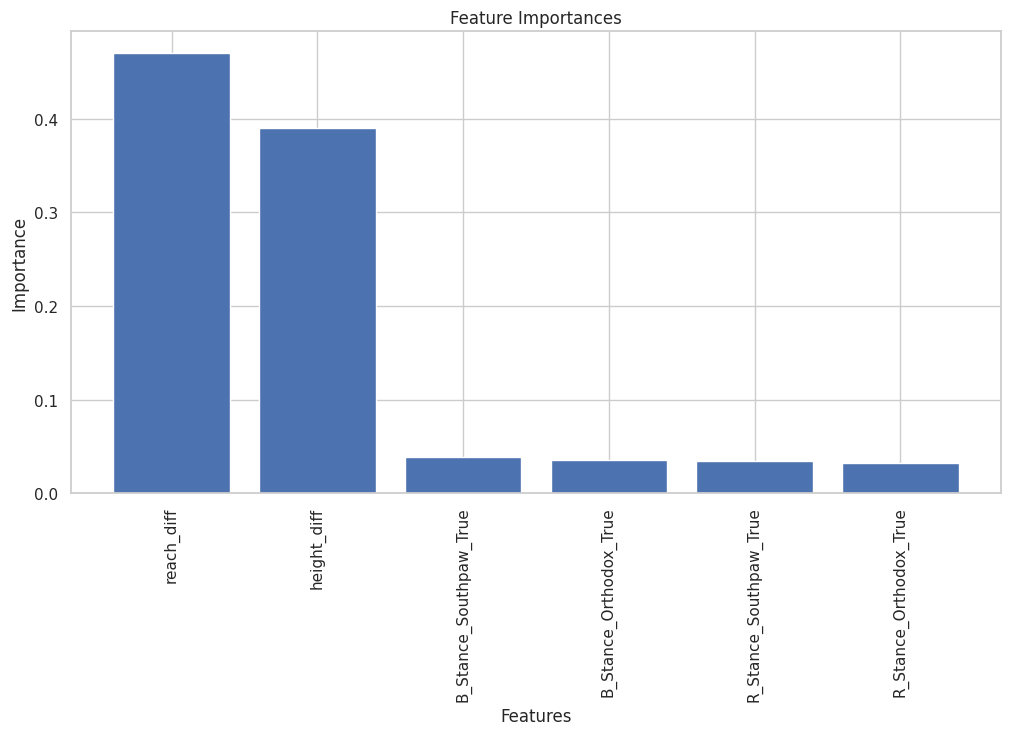

In [ ]:
best_model = grid_search.best_estimator_.named_steps['randomforestclassifier']

# Get feature importances
importances = best_model.feature_importances_

# Get feature names from the dataset
feature_names = X.columns

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

###Make a graph that contrasts certain values to see which are the most important for improving consistency and accuracy in our dataframe

In [ ]:
# Define the important columns
important_columns = ['height_diff', 'reach_diff', 'R_Stance_Orthodox_True', 'R_Stance_Southpaw_True', 'B_Stance_Orthodox_True', 'B_Stance_Southpaw_True']

# Select only the important columns from your dataset
X_important = X[important_columns]

# Now you can use a simpler pipeline without the ColumnTransformer
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Impute missing values
    RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_split=20, min_samples_leaf=8, max_features='sqrt')
)

# Fit the pipeline
pipeline.fit(X_important, y)

# Filter the DataFrame to only include important features
X_filtered = X.filter(items=important_columns)

for col in important_columns:
    if col not in X_test.columns:
        X_test[col] = np.nan

X_test_important = X_test[important_columns]

predictions = pipeline.predict(X_test_important)


###Use important columns to make and fit a RandomForestClassifier pipeline (use pipeline here instead of model because of the versatility in functions).

In [ ]:
def prepare_input_data(fighter1, fighter2):
    height_diff = fighter1['R_Height_cms'] - fighter2['B_Height_cms']
    reach_diff = fighter1['R_Reach_cms'] - fighter2['B_Reach_cms']

    data = {
        'height_diff': [height_diff],
        'reach_diff': [reach_diff],
        'R_Stance_Orthodox_True': [fighter1.get('R_Stance_Orthodox', 0)],
        'R_Stance_Southpaw_True': [fighter1.get('R_Stance_Southpaw', 0)],
        'B_Stance_Orthodox_True': [fighter2.get('B_Stance_Orthodox', 0)],
        'B_Stance_Southpaw_True': [fighter2.get('B_Stance_Southpaw', 0)]
    }

    return pd.DataFrame(data)

###Create a function called prepare_input_data which prepares the data of 2 fighters by making and returning a new dataframe called data. This dataframe holds the height diff, reach diff, and if each fighter stance is Southpaw or Orthodox.

In [ ]:
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,...,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,experience_diff,height_diff,reach_diff,age_diff,winner_is_red,Total_Rounds_Fought
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.000000,0.0,0.004200,...,True,False,False,False,3,5.08,7.62,4.0,1,5
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.500000,0.0,0.006600,...,True,False,False,False,13,5.08,5.08,4.0,1,21
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,0.015625,0.0,0.004500,...,True,False,False,False,13,0.00,0.00,4.0,1,13
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.015625,0.0,0.004500,...,False,False,True,False,0,7.62,5.08,3.0,0,0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,0.125000,0.0,0.005356,...,True,False,False,False,19,12.70,10.16,14.0,0,41


In [ ]:
def fighter_details(df, name):
    if name in df['R_fighter'].values:
        fighter_details = df[df['R_fighter'] == name].iloc[0]
        fighter_details['corner'] = 'R'  # Indicate this fighter is in the red corner
        fighter_details['name'] = name
        return fighter_details
    elif name in df['B_fighter'].values:
        fighter_details = df[df['B_fighter'] == name].iloc[0]
        fighter_details['corner'] = 'B'  # Indicate this fighter is in the blue corner
        fighter_details['name'] = name
        return fighter_details
    else:
        raise ValueError("Fighter not found in the database")

def display_fighter_info(fighter):
    print("\nFighter Details:")
    print(f"Name: {fighter['name']}")
    print(f"Height: {fighter[fighter['corner'] + '_Height_cms']} cms")
    print(f"Reach: {fighter[fighter['corner'] + '_Reach_cms']} cms")

    # Determine the stance based on which 'Stance_' column is True
    stances = ['Orthodox', 'Sideways', 'Southpaw', 'Switch']
    stance = 'Unknown'
    for st in stances:
        if fighter.get(fighter['corner'] + '_Stance_' + st, False):
            stance = st
            break

    print(f"Stance: {stance}")


###Create a function called fighter_details. This function accepts the dataframe and the name of one of the fighters. It returns a new dataframe from that fighter that has the corner and name of the fighter. If this fighter isn't found it will print 'Fighter not found in the database'.
###Create a function called display_fighter_info. This function accepts one fighter. This function displays the Name, Height, Reach, and stance(s) of the fighter.

In [ ]:
def plot_prediction_probabilities(probabilities, fighters):
    plt.figure(figsize=(8, 4))
    plt.bar(fighters, probabilities[0], color=['red', 'blue'])
    plt.xlabel('Fighters')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
    plt.ylim(0, 1)
    plt.show()

def plot_key_stats_comparison(fighter1, fighter2, stats):
    stats = ['Height_cms', 'Reach_cms']
    # Adjust the stats names based on the corner of the fighter
    values1 = [fighter1[fighter1['corner'] + '_' + stat] for stat in stats]
    values2 = [fighter2[fighter2['corner'] + '_' + stat] for stat in stats]

    indices = range(len(stats))
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(indices, values1, bar_width,
                     alpha=opacity, color='b', label=fighter1['name'])

    rects2 = plt.bar([p + bar_width for p in indices], values2, bar_width,
                     alpha=opacity, color='r', label=fighter2['name'])

    plt.xlabel('Stats')
    plt.ylabel('Values')
    plt.title('Comparison of Key Fighter Stats')
    plt.xticks([p + bar_width for p in indices], stats)
    plt.legend()

    plt.tight_layout()
    plt.show()

###Create a function called plot_prediction_probabilities. This function accepts the probabilities and the two fighters. It simply plots the probability of winning for both fighters.
###Create a function called plot_key_stats_comparison. This function accepts both fighters and the stats that were put in place from where it was called. The purpose of this function is to create a graph which shows how the two fighters compare on the stats inputed. These will be shown on the same graph.

In [ ]:
def handle_fight_prediction(df, pipeline, fighter1_name, fighter2_name):
    try:
        R_fighter = fighter_details(df, fighter1_name)  # Red corner
        B_fighter = fighter_details(df, fighter2_name)  # Blue corner

        display_fighter_info(R_fighter)
        display_fighter_info(B_fighter)

        input_data = prepare_input_data(R_fighter, B_fighter)
        prediction = pipeline.predict(input_data)
        pred_proba = pipeline.predict_proba(input_data)

        fighters = [fighter1_name, fighter2_name]
        print(f"\nPrediction: {'Red corner (Fighter 1) wins' if prediction[0] == 1 else 'Blue corner (Fighter 2) wins'}")
        print(f"Prediction probabilities: {pred_proba}")

        plot_prediction_probabilities(pred_proba, fighters)
        plot_key_stats_comparison(R_fighter, B_fighter, ['Height_cms', 'Reach_cms'])

    except ValueError as e:
        print(e)

###Create a function called handle_fight_predictions which parameters are the dataframe, pipeline, and the two fighters. This is all within a Try statement. Call the previous function made called fighter_details for the two fighters. After, call display_fighter_info for both the fighters. After, prepare the data with the previously made function prepare_input_data which accepts both fighters. Once the data is prepared, it then predicts who will win and shows the odds of the two fighters. After, call the function plot_prediction_probabilities which accepts the prediction probability and the two fighters. Lastly, call plot_key_stats_comparison which accepts both fighters and a comparison of stats of our choosing. If there's any error inside the try statement, it will be caught and printed.

In [ ]:
def select_fighters_and_predict(df, pipeline):
    fighter1_name = input("Enter the name of the red corner fighter: ")
    fighter2_name = input("Enter the name of the blue corner fighter: ")

    handle_fight_prediction(df, pipeline, fighter1_name, fighter2_name)

    try:
        R_fighter = fighter_details(df, fighter1_name)  # Red corner
        B_fighter = fighter_details(df, fighter2_name)  # Blue corner

        input_data = prepare_input_data(R_fighter, B_fighter)

        prediction = pipeline.predict(input_data)
        pred_proba = pipeline.predict_proba(input_data)

        print(f"Prediction: {'Red corner (Fighter 1) wins' if prediction == 1 else 'Blue corner (Fighter 2) wins'}")
        print(f"Prediction probabilities: {pred_proba}")

    except ValueError as e:
        print(e)

###Create a function called select_fighters_and_predict which asks you to input the name of 2 fighters in either the red or blue corner. Then it calls the function handle_fight_prediction with the parameters of the dataframe, pipeline, and the two fighters. Then it goes into a try statement where it calls fighter_details on both fighters. After, it prepares the data through the function previously made called prepare_input_data with the parameters of the two fighters. It then predicts who will win and shows the odds of the two fighters. If any error is made inside the try statement, it will catch it and then print the error.

Enter the name of the red corner fighter: Max Holloway
Enter the name of the blue corner fighter: Khabib Nurmagomedov

Fighter Details:
Name: Max Holloway
Height: 180.34 cms
Reach: 175.26 cms
Stance: Orthodox

Fighter Details:
Name: Khabib Nurmagomedov
Height: 177.8 cms
Reach: 177.8 cms
Stance: Orthodox

Prediction: Red corner (Fighter 1) wins
Prediction probabilities: [[0.26526491 0.73473509]]


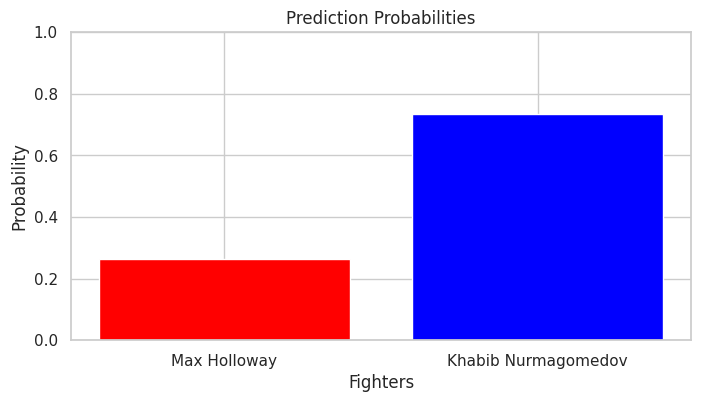

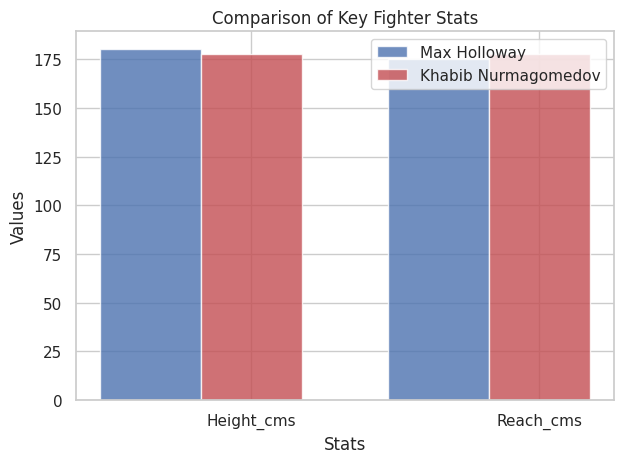

Prediction: Red corner (Fighter 1) wins
Prediction probabilities: [[0.26526491 0.73473509]]


In [ ]:
select_fighters_and_predict(df, pipeline)
#Conor McGregor
#Max Holloway
#Khabib Nurmagomedov
#Dustin Poirier
#Jon Jones
#Nick Diaz
#Israel Adesanya
#Chuck Liddell
#Justin Gaethje

###Call select_fighters_and_predict and use the dataframe and pipeline. :)

In [ ]:
df.head()

##This notebook fully encapsulate what we meant to do in our project proposal. Our proposal was "Our plan is to build a model that will be able to predict the winner of potential fights", and we believe we have achieved that to the best of our abilities.